# Lab 4
## More Data Scraping and EDA

In this lab, you will improve your skills in scraping data from web pages, organizing the data in a desired format, and performing EDA.

For this lab, we are reusing code from Harvard's CS109: https://github.com/cs109/2015/blob/master/Lectures/02-DataScrapingQuizzes.ipynb

## Lab3.A. Run code for scraping Indeed.com data

You firs task will be to exectute the following blocks of code and try to understand what is happening after each line of the code. You will have to answer several questions to show your understanding.

Let us start with importing of the relevant packages.

In [1]:
import urllib2
import bs4 #this is beautiful soup

import time
from pandas import Series
import pandas as pd
from pandas import DataFrame
import numpy as np
import re

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

As you see, you imported the package called `re`, which supports regular expression operations. You have already used the other packages. 

The following block will access and load the contents of an Indeed.com web page. It will probably give you a warning -- please ignore it.

In [2]:
# Fixed url for job postings containing data scientist
url = 'http://www.indeed.com/jobs?q=data+scientist&l='
# read the website
source = urllib2.urlopen(url).read()
# parse html code
bs_tree = bs4.BeautifulSoup(source)

/Users/chaunguyen/anaconda3/envs/py27/lib/python2.7/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("html5lib"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 174 of the file /Users/chaunguyen/anaconda3/envs/py27/lib/python2.7/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "html5lib")

  markup_type=markup_type))


** Question 1**:
 * What kind of page did you land on? Explain in a few sentences what is the content of this page.
 * What does the "?" and "&" in the url mean?
 * Explore the content of the web page. If you are using Firefox, open the page Inspector to understand how the underlying html code relates to the displayed content.
 * What pieces of the html code are responsible for showing the job title, company name, and job location?
 
The following block of code will figure out how many job ads are there for jobs that contain "data scientist' in the job title.

**Answer 1:** 
- It's a webpage called indeed.com. This page provide all the job open position of job title: Data Scientist with location leave blank
- The ? indicates the start of the query string. The & separated the pairs key=value within the query string
- Pieces of the html code are responsible for showing the job title, company name, and job location:  company name: 'span',"class":"company""  job_location:'span',"class":"location" job_title:'a',"data-tn-element":"jobTitle"

In [3]:
# see how many job postings we found
job_count_string = bs_tree.find(id = 'searchCount').contents[0]
job_count_string = job_count_string.split()[-2]
print("Search yielded %s hits." % (job_count_string))

# not that job_count so far is still a string, 
# not an integer, and the , separator prevents 
# us from just casting it to int

job_count_digits = [int(d) for d in job_count_string if d.isdigit()]
job_count = np.sum([digit*(10**exponent) for digit, exponent in 
                    zip(job_count_digits[::-1], range(len(job_count_digits)))])

print job_count

Search yielded 24,669 hits.
24669


** Question 2**:
* What does the "find(id = 'searchCount')" in the first line mean?
* What does the second line do?

**Question 3**: 
* Write a piece of code that finds the Salary Estimate object on the page


**Answer 2:** 
- It will go get all the contents in the container call id="searchCount"
- The sencond line take the content within that id and splits it into separate words. After that, take the 2nd word from the right


**Answer 3:**

In [4]:
salary_estimate_string = bs_tree.find(id = 'rb_Salary_Estimate')

The following piece of code allows you to find the links to all the job ads on the page.

In [5]:
# The website is only listing 10 results per page, 
# so we need to scrape them page after page
num_pages = int(np.ceil(job_count/10.0))

base_url = 'http://www.indeed.com'
job_links = []
for i in range(1): #do range(num_pages) if you want them all
    url = 'http://www.indeed.com/jobs?q=data+scientist&start=' + str(i*10)
    html_page = urllib2.urlopen(url).read() 
    bs_tree = bs4.BeautifulSoup(html_page)
    job_link_area = bs_tree.find(id = 'resultsCol')
    job_postings = job_link_area.findAll("div")
    job_postings = [jp for jp in job_postings if not jp.get('class') is None 
                 and ''.join(jp.get('class')) =="rowresult"]
    
    job_ids = [jp.get('data-jk') for jp in job_postings]
    
    # go after each link
    for id in job_ids:
        job_links.append(base_url + '/rc/clk?jk=' + id)
        time.sleep(1)

print "We found a lot of jobs: ", len(job_links)
print job_links

We found a lot of jobs:  13
[u'http://www.indeed.com/rc/clk?jk=9620b9780a6f0f15', u'http://www.indeed.com/rc/clk?jk=86265e9836292a1c', u'http://www.indeed.com/rc/clk?jk=4387cc56a99a4b26', u'http://www.indeed.com/rc/clk?jk=d3db5c3015779bc7', u'http://www.indeed.com/rc/clk?jk=60a06343d151e96e', u'http://www.indeed.com/rc/clk?jk=f431f2674f6964eb', u'http://www.indeed.com/rc/clk?jk=7823ea137e68e0d7', u'http://www.indeed.com/rc/clk?jk=3951010b99ea3278', u'http://www.indeed.com/rc/clk?jk=ef4684eea3d40e2c', u'http://www.indeed.com/rc/clk?jk=e52287bf8b1ad63e', u'http://www.indeed.com/rc/clk?jk=552f277e352b2be6', u'http://www.indeed.com/rc/clk?jk=18d62b0ae65c022e', u'http://www.indeed.com/rc/clk?jk=a7a3f3c2ec0c0d7c']


**Question 4**:
* explain why is `url` (first line in the for loop) defined as it is. What page are you landing at when `i = 3`?
* What does command `bs_tree.find(id = 'resultsCol')` do?
* What does command `''.join(jp.get('class'))` do?
* Explain the properties and content of `job_links`


**Answer 4**
- The url = 'http://www.indeed.com/jobs?q=data+scientist&start=' + str(i*10) with i = i in range(1) will give us the url page 1, which contains job 1 to 10. It's because there is 10 jobs in each page. If if set i=3, it will bring us to page 3, which hold job 31 to 40. 
- bs_tree.find(id = 'resultsCol') will return all the contents in the container id = 'resultsCol'
- ''.join(jp.get('class')) will join sequence of string from 'class' and join it together
- job_links is a list contain all the urls that direct to each specific job page 



**Question 5**:
* Reuse the code above to find links to the first 200 listed data science jobs



**Answer5**

In [55]:
num_pages = int(np.ceil(job_count/10.0))
job_counter=0
base_url = 'http://www.indeed.com'
top200_job_links = []
for i in range(25): #do range(num_pages) if you want them all
    if (job_counter==200):
        break
    else:
        url = 'http://www.indeed.com/jobs?q=data+scientist&start=' + str(i*10)
        html_page = urllib2.urlopen(url).read() 
        bs_tree = bs4.BeautifulSoup(html_page)
        job_link_area = bs_tree.find(id = 'resultsCol')
        job_postings = job_link_area.findAll("div")
        job_postings = [jp for jp in job_postings if not jp.get('class') is None 
                     and ''.join(jp.get('class')) =="rowresult"]

        job_ids = [jp.get('data-jk') for jp in job_postings]

        # go after each link
        for id in job_ids:
            if(job_counter==200):
                break
            else:
                top200_job_links.append(base_url + '/rc/clk?jk=' + id)
                job_counter+=1
                #time.sleep(1)

print "We found a lot of jobs: ", len(top200_job_links)
print top200_job_links

We found a lot of jobs:  200
[u'http://www.indeed.com/rc/clk?jk=dfee70c40a74b575', u'http://www.indeed.com/rc/clk?jk=8e58b7c7c537fefe', u'http://www.indeed.com/rc/clk?jk=c227e8886b77645d', u'http://www.indeed.com/rc/clk?jk=d3db5c3015779bc7', u'http://www.indeed.com/rc/clk?jk=60a06343d151e96e', u'http://www.indeed.com/rc/clk?jk=f431f2674f6964eb', u'http://www.indeed.com/rc/clk?jk=7823ea137e68e0d7', u'http://www.indeed.com/rc/clk?jk=3951010b99ea3278', u'http://www.indeed.com/rc/clk?jk=ef4684eea3d40e2c', u'http://www.indeed.com/rc/clk?jk=e52287bf8b1ad63e', u'http://www.indeed.com/rc/clk?jk=552f277e352b2be6', u'http://www.indeed.com/rc/clk?jk=18d62b0ae65c022e', u'http://www.indeed.com/rc/clk?jk=40642ede2fe33a42', u'http://www.indeed.com/rc/clk?jk=a8047241a6789726', u'http://www.indeed.com/rc/clk?jk=d1c3e7de4a25812c', u'http://www.indeed.com/rc/clk?jk=a749cab903f7a602', u'http://www.indeed.com/rc/clk?jk=96807fbe1eb150b5', u'http://www.indeed.com/rc/clk?jk=b12d494b95417cc3', u'http://www.ind

The following piece of code accesses and grabs the content of all ads in the `job_links` and extracts all the human-readable text tokens. Then, it counts on how many pages are words `mapreduce`, `spark`, and `visualization` used. It might take a few seconds to execute.

In [9]:
print job_links

[u'http://www.indeed.com/rc/clk?jk=8e58b7c7c537fefe', u'http://www.indeed.com/rc/clk?jk=4387cc56a99a4b26', u'http://www.indeed.com/rc/clk?jk=69b5a4b90fecad45', u'http://www.indeed.com/rc/clk?jk=fe62709fb9ad37c2', u'http://www.indeed.com/rc/clk?jk=18d62b0ae65c022e', u'http://www.indeed.com/rc/clk?jk=bba42446f1492e47', u'http://www.indeed.com/rc/clk?jk=d3db5c3015779bc7', u'http://www.indeed.com/rc/clk?jk=f431f2674f6964eb', u'http://www.indeed.com/rc/clk?jk=552f277e352b2be6', u'http://www.indeed.com/rc/clk?jk=9e1122875a6fbf57', u'http://www.indeed.com/rc/clk?jk=60a06343d151e96e', u'http://www.indeed.com/rc/clk?jk=55b32f3d7960cacd', u'http://www.indeed.com/rc/clk?jk=b3d0a902a4f1a346']


In [17]:
skill_set = {'mapreduce':0, 'spark':0, 'visualization':0}
counter = 0
for link in job_links:
    counter +=1  
    try:
        html_page = urllib2.urlopen(link).read()
    except urllib2.HTTPError:
        print "HTTPError:"
        continue
    except urllib2.URLError:
        print "URLError:"
        continue
    except socket.error as error:
        print "Connection closed"
        continue

    html_text = re.sub("[^a-z.+3]"," ", html_page.lower()) # replace all but the listed characters
        
    for key in skill_set.keys():
        if key in html_text:  
            skill_set[key] +=1
            
    if counter % 5 == 0:
        print len(job_links) - counter
        print skill_set
            
print skill_set

8
{'visualization': 2, 'spark': 1, 'mapreduce': 0}
3
{'visualization': 4, 'spark': 2, 'mapreduce': 0}
HTTPError:
{'visualization': 4, 'spark': 3, 'mapreduce': 0}


** Question 6**
* What does the `re.sub()` do in the above code? To answer this, you will have to go to the documentation of the regular expression package (find it on web).
* What is the meaning of `[^a-z.+3]`?
* What is the content of `skill_set`?

The following piece of code plots the counts of different skills in the processed ads.

**Answer 6**
- re.sub return the string obtained by replacing the leftmost non-overlapping occurrences of pattern in string by the replacement repl. If the pattern isn’t found, string is returned unchanged.
- [^a-z.+3] that can be anything but lower case a to lower case z and any 3 pattern characters
- skill_set is a dictionary contains all the key words and number of repetation.

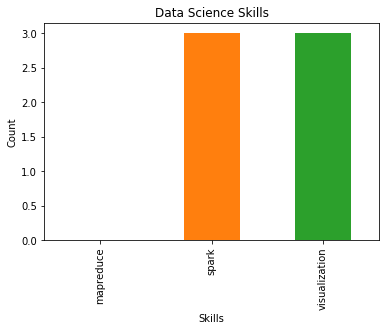

In [15]:
pseries = pd.Series(skill_set)
pseries.sort_values(ascending=False)

pseries.plot(kind = 'bar')
## set the title to Score Comparison
plt.title('Data Science Skills')
## set the x label
plt.xlabel('Skills')
## set the y label
plt.ylabel('Count')
## show the plot
plt.show()

**Question 7**:
- rerun the code to find the counts of the 3 data science skills on the first 200 job ads

In [56]:
skill_set = {'mapreduce':0, 'spark':0, 'visualization':0}
counter = 0
for link1 in top200_job_links:
    counter +=1  
    try:
        html_page = urllib2.urlopen(link1).read()
    except urllib2.HTTPError:
        print "HTTPError:"
        continue
    except urllib2.URLError:
        print "URLError:"
        continue
    except socket.error as error:
        print "Connection closed"
        continue

    html_text1 = re.sub("[^a-z.+3]"," ", html_page.lower()) # replace all but the listed characters
        
    for key in skill_set.keys():
        if key in html_text1:  
            skill_set[key] +=1
            
    if counter % 5 == 0:
        print len(top200_job_links) - counter
        print skill_set
            
print skill_set

195
{'visualization': 1, 'spark': 0, 'mapreduce': 0}
190
{'visualization': 3, 'spark': 1, 'mapreduce': 0}
185
{'visualization': 4, 'spark': 3, 'mapreduce': 0}
180
{'visualization': 5, 'spark': 4, 'mapreduce': 0}
HTTPError:
175
{'visualization': 7, 'spark': 5, 'mapreduce': 0}
170
{'visualization': 9, 'spark': 5, 'mapreduce': 0}
HTTPError:
165
{'visualization': 9, 'spark': 6, 'mapreduce': 0}
160
{'visualization': 10, 'spark': 7, 'mapreduce': 0}
HTTPError:
155
{'visualization': 11, 'spark': 8, 'mapreduce': 1}
150
{'visualization': 11, 'spark': 9, 'mapreduce': 1}
HTTPError:
145
{'visualization': 13, 'spark': 11, 'mapreduce': 1}
HTTPError:
140
{'visualization': 14, 'spark': 13, 'mapreduce': 1}
HTTPError:
135
{'visualization': 14, 'spark': 14, 'mapreduce': 1}
130
{'visualization': 15, 'spark': 16, 'mapreduce': 1}
125
{'visualization': 17, 'spark': 18, 'mapreduce': 2}
HTTPError:
120
{'visualization': 18, 'spark': 20, 'mapreduce': 2}
115
{'visualization': 20, 'spark': 22, 'mapreduce': 3}
HTTPE

## Lab 3.B: Data analysis of job skills
In the first part of the lab, you created `skill_set` dictionary that counts occurences of 3 important data science skills. In this part of the lab we are asking you to create pandas `DataFrame` object as a table whose rows correspond to individual ads and columns correspond to important information about the ads and skills mentioned on those pages. Let us call the table `job_ads`. Process the first 1,000 data science ads, so your table should have 1,000 rows. For each ad, you will have to create the following columns:
- job title
- company name
- job location
- skill 1
- skill 2
- ...
- skill 20

Job title, company name, and job locations will be readable from the Indeed.com page. We are asking you to list 20 skills, instead of only 3 in the code above ('mapreduce', 'spark', 'visualization'). You will need to find another 17 words that are commonly used in data science job ads. To do it, please explore the content of at least 10 ads.

Once you creat your `job_ads` table, please preform EDA of the table, in a similar way you did in Lab 2: provide code and a 2-page document that summarizes interesitng insights about the first 1,000 data science jobs.

**Deliverables**:
- the modified Lab 4 .ipynb file that contains all the answers to the questions
- a 2-page documents presenting the results of your EDA of the `job_ads` data

In [1]:
# create emplty df
job_ads = pd.DataFrame()
job_counter=0
base_url = 'http://www.indeed.com'
job_links = []
for i in range(140): #125 for at least 1000 jobs
    url = 'http://www.indeed.com/jobs?q=data+scientist&start=' + str(i*10)
    html_page = urllib2.urlopen(url).read() 
    bs_tree = bs4.BeautifulSoup(html_page)
    job_link_area = bs_tree.find(id = 'resultsCol')
    job_postings = job_link_area.findAll("div")
    job_postings = [jp for jp in job_postings if not jp.get('class') is None 
                 and ''.join(jp.get('class')) =="rowresult"]
    for jp in job_postings:
        if (job_counter==1000):
            break
        else:
            company_name= jp.find('span',{"class":"company"}).getText().strip()
            job_location=jp.find('span',{"class":"location"}).getText().strip()
            job_title=jp.find('a',{"data-tn-element":"jobTitle"}).getText().strip()
            link= "%s%s"% (base_url,jp.find('a').get('href'))
            skill_set={"Job title":job_title, "Location":job_location, "Company":company_name,
                     "analytical":0, "python":0, "communication":0, "quantitative":0,
                     "sql":0, "java":0, "sas":0, "cloud":0, "scala":0,"julia":0,
                       "tableau":0, "query":0, "computer science":0, "degree":0, "python":0,
                       "r":0, "hive":0, "nlp":0, "hadoop":0,"matlab":0
                     }
            
            try:
                html_page = urllib2.urlopen(link).read()
            except urllib2.HTTPError:
                continue
            except urllib2.URLError:
                continue
            #except socket.error as error:
                continue

            html_text1 = re.sub("[^a-z.+3]"," ", html_page.lower()) # replace all but the listed characters
        
            for key in skill_set.keys():
                if key in html_text1:  
                    skill_set[key] =1
            #print skill_set
            
            job_ads=job_ads.append(skill_set,ignore_index=True)
        
  

NameError: name 'pd' is not defined

In [9]:
job_ads.shape

(1365, 22)

In [10]:
total_skill= job_ads.sum(axis=None, skipna=None, level=None, numeric_only=True, min_count=0)
#job_ads.sum(numeric_only=True)
print total_skill

analytical           625.0
cloud                796.0
communication        673.0
computer science     722.0
degree               790.0
hadoop               337.0
hive                 189.0
java                1365.0
julia                 11.0
matlab               143.0
nlp                   98.0
python               970.0
quantitative         524.0
query               1365.0
r                   1365.0
sas                 1364.0
scala                379.0
sql                  767.0
tableau              242.0
dtype: float64


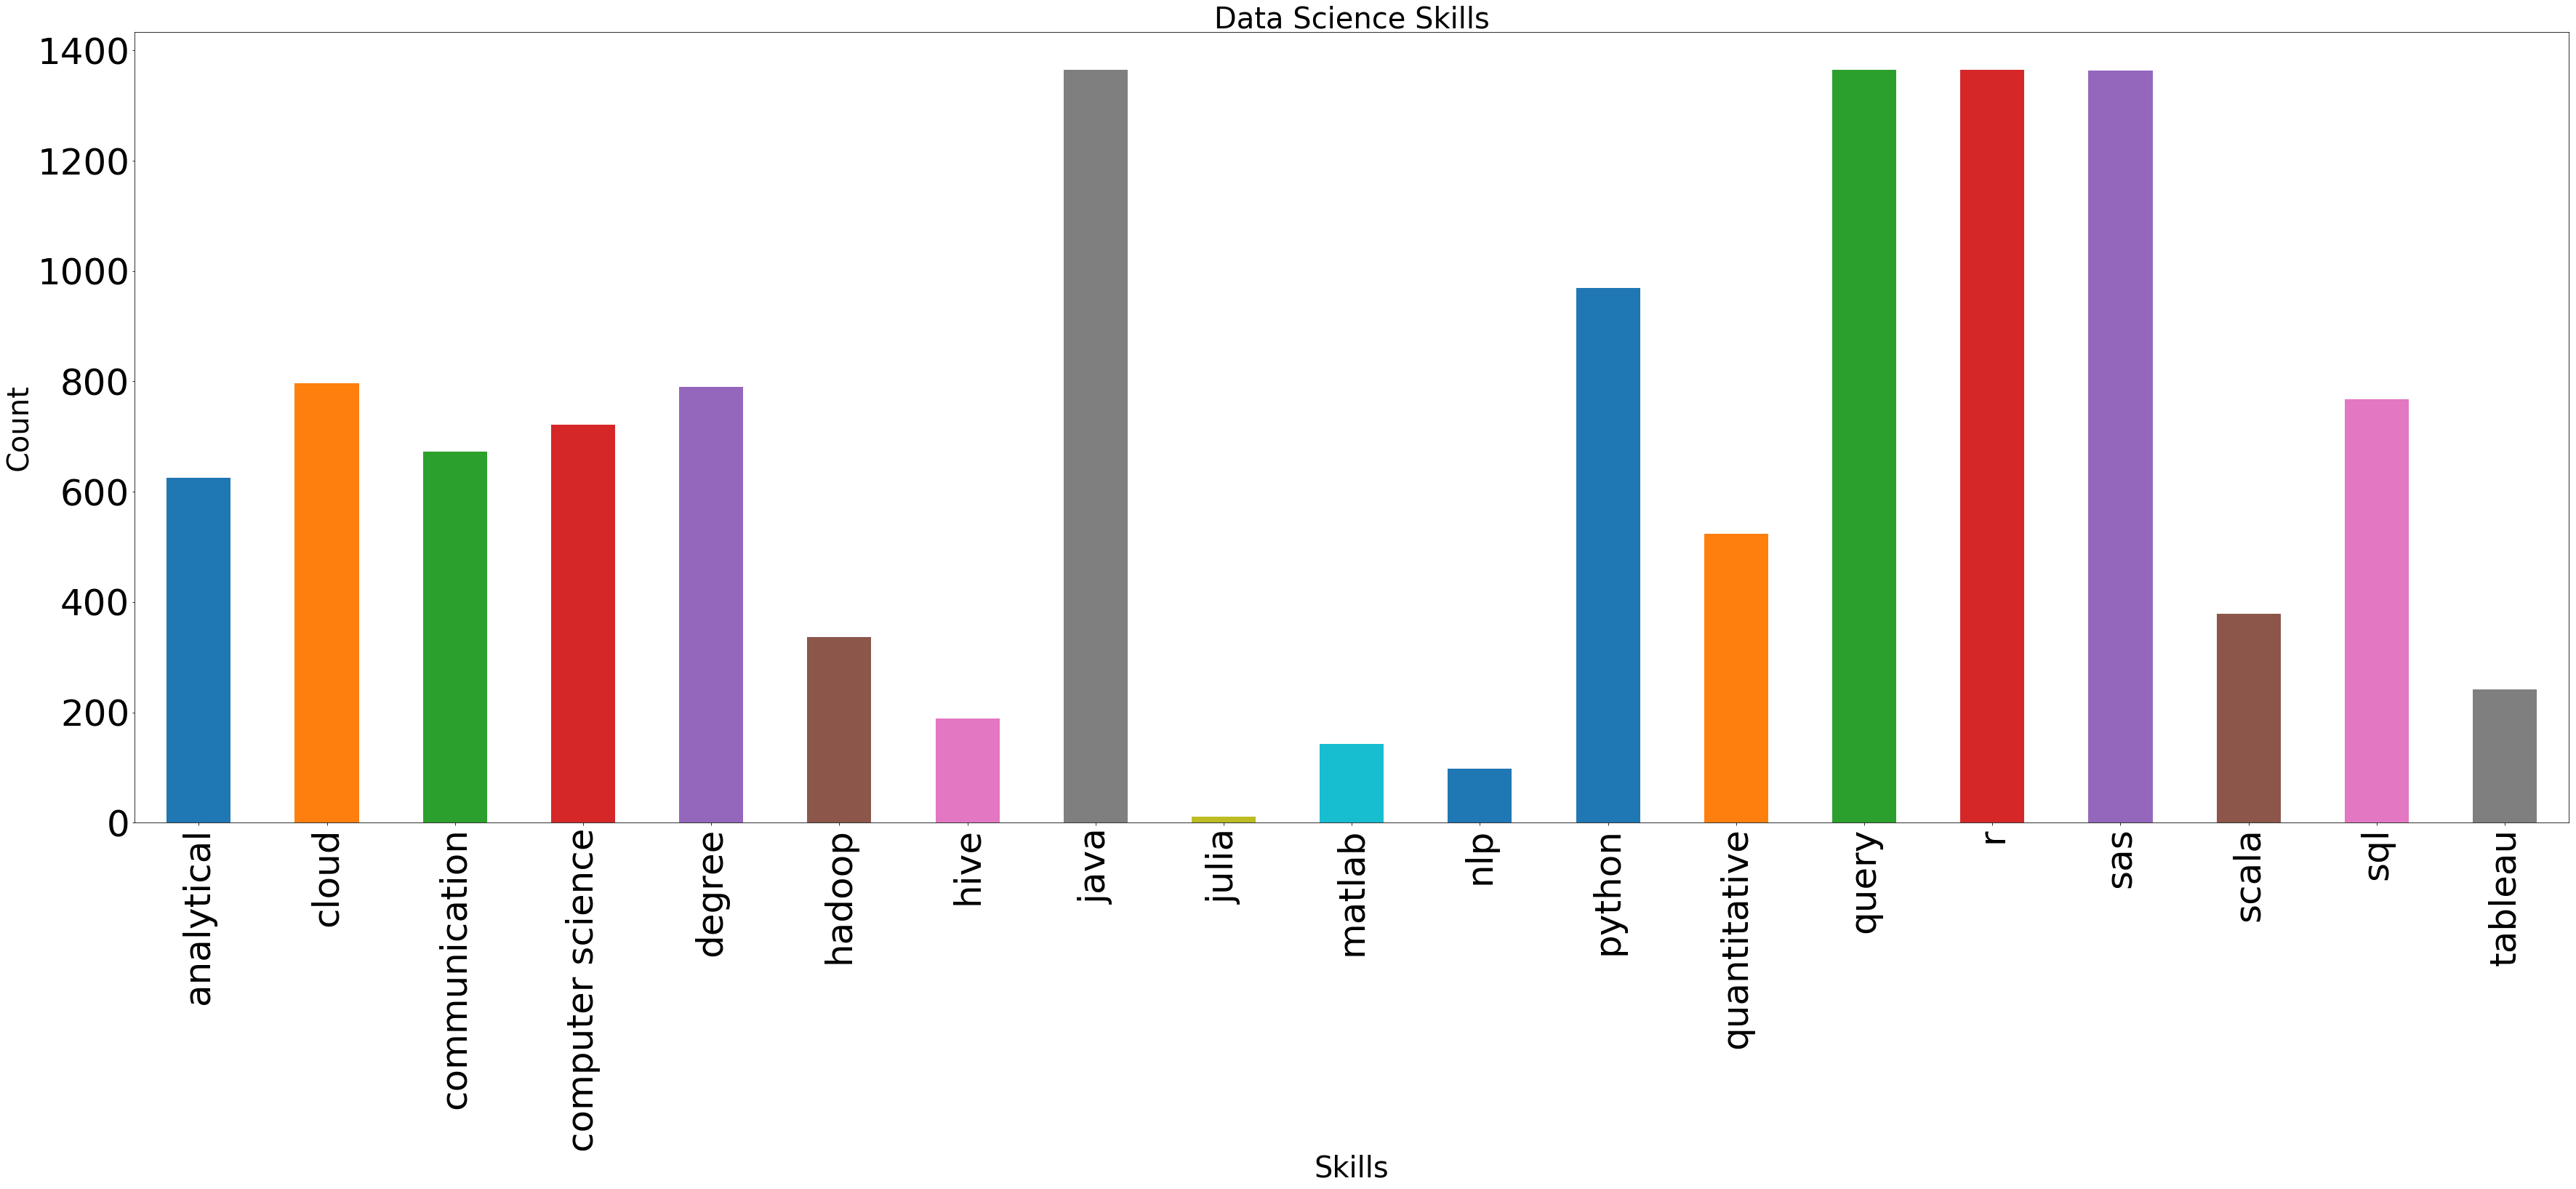

In [11]:
fig = plt.figure(figsize=(60,20))
pseries = pd.Series(total_skill)
pseries.sort_values(ascending=True)

pseries.plot(kind = 'bar')
## set the title to Score Comparison
plt.title('Data Science Skills',fontsize=40)
## set the x label
plt.xlabel('Skills',fontsize=40)
## set the y label
plt.ylabel('Count',fontsize=40)
plt.tick_params(labelsize=50)
## show the plot
plt.show()

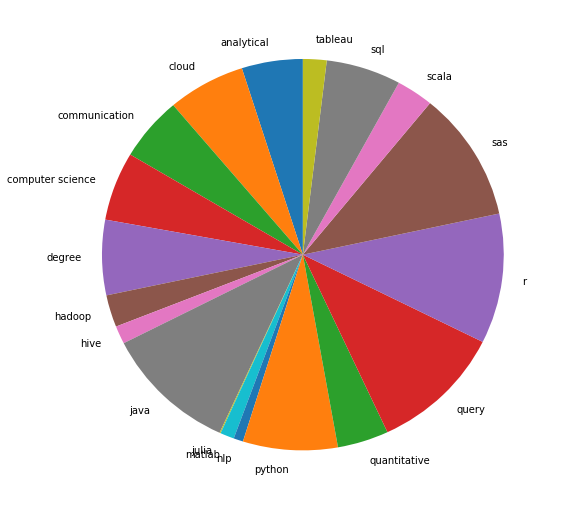

In [17]:
plt.figure(figsize=(9,9))
#plt.axis("equal")
plt.pie(total_skill,labels=total_skill.index,startangle=90);
plt.labelsize=50